In [ ]:
from dotenv import load_dotenv
load_dotenv()                       # looks for .env in the current dir
import os
API_KEY = os.getenv("POLYGON_API_KEY")


X7QL9P ...


11,137 symbols returned; 11,059 had non-zero volume.


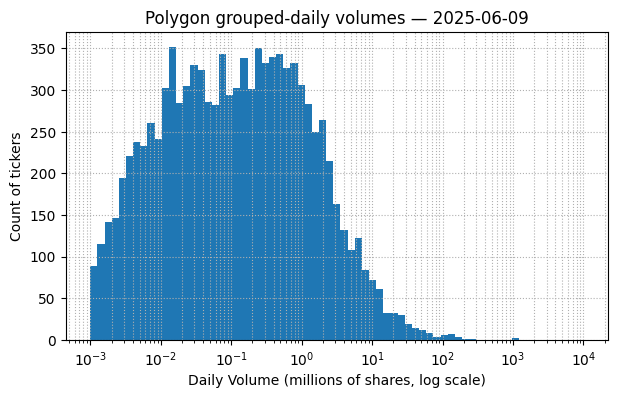

In [14]:
import os, requests, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

API_KEY = os.getenv("POLYGON_API_KEY")

# 1️⃣  pick yesterday’s market date (skips weekends/holidays)
trade_date = (pd.Timestamp("today", tz="America/New_York") - BDay(1)).date()

# 2️⃣  call grouped-daily endpoint
url = (f"https://api.polygon.io/v2/aggs/grouped/locale/us/market/stocks/"
       f"{trade_date}?adjusted=true&apiKey={API_KEY}")
resp = requests.get(url, timeout=20).json()
bars = pd.DataFrame(resp["results"])        # ~10k rows

# 3️⃣  basic cleanup → volume in millions for readability
bars["volume_mil"] = bars["v"] / 1_000_000

# quick sanity: how many symbols actually traded?
print(f"{len(bars):,} symbols returned; "
      f"{(bars['v']>0).sum():,} had non-zero volume.")

# 4️⃣  histogram (matplotlib - no seaborn, single axis, default colors)
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(bars["volume_mil"], bins=np.logspace(-3,4,70))
ax.set_xscale("log")
ax.set_xlabel("Daily Volume (millions of shares, log scale)")
ax.set_ylabel("Count of tickers")
ax.set_title(f"Polygon grouped-daily volumes — {trade_date}")
ax.grid(True, which="both", ls=":")
plt.show()


In [15]:
import numpy as np, pandas as pd

# simple percentile table
print(bars['v'].quantile([.25,.5,.75,.9,.95,.99]).astype(int))

# count symbols in intuitive buckets
bucket_edges = [0, 1e3, 1e4, 1e5, 1e6, 1e7, np.inf]
labels = ["<1k","1k-10k","10k-100k","100k-1M","1M-10M",">10M"]
bars['bucket'] = pd.cut(bars['v'], bucket_edges, labels=labels, right=False)
print(bars['bucket'].value_counts().sort_index())


0.25        9893
0.50       80791
0.75      594417
0.90     2274896
0.95     5145292
0.99    22790471
Name: v, dtype: int64
bucket
<1k          949
1k-10k      1843
10k-100k    3053
100k-1M     3234
1M-10M      1780
>10M         278
Name: count, dtype: int64


In [16]:
import numpy as np, pandas as pd

bucket_edges = [0, 1e3, 1e4, 1e5, 1e6, 1e7, np.inf]
labels       = ["<1k","1k-10k","10k-100k","100k-1M","1M-10M",">10M"]

bars["bucket"] = pd.cut(bars["v"], bucket_edges, labels=labels, right=False)

# sanity-check
display(bars["bucket"].value_counts().sort_index())



bucket
<1k          949
1k-10k      1843
10k-100k    3053
100k-1M     3234
1M-10M      1780
>10M         278
Name: count, dtype: int64

In [18]:
bars

,T,v,vw,o,c,h,l,t,n,volume_mil,bucket
0,CGCB,1140541.0,25.90650,25.8600,25.9100,25.9200,25.840000,1749499200000,1914.0,1.140541,1M-10M
1,LTH,7171782.0,28.15130,28.9400,28.0400,29.0150,27.940000,1749499200000,45615.0,7.171782,1M-10M
2,MJ,41236.0,18.90870,19.0600,18.8800,19.2100,18.740000,1749499200000,631.0,0.041236,10k-100k
3,KITTW,63086.0,0.06352,0.0593,0.0602,0.0739,0.055100,1749499200000,105.0,0.063086,10k-100k
4,MSTR,10924592.0,387.46410,380.6800,392.1200,394.7900,377.600000,1749499200000,232963.0,10.924592,>10M
...,...,...,...,...,...,...,...,...,...,...,...
11132,ZXZZT,10331.0,16.01750,12.1000,12.1200,12.1200,12.100000,1749499200000,222.0,0.010331,10k-100k
11133,ZWZZT,5000.0,10.00000,10.0000,10.0000,10.0000,10.000000,1749499200000,1.0,0.005000,1k-10k
11134,ZIEXT,7389.0,0.99190,1.0000,1.0000,1.0000,0.990217,1749499200000,7.0,0.007389,1k-10k
11135,ZTEST,4137.0,8116.66710,8187.8159,8187.8159,8187.8159,8187.815900,1749499200000,8.0,0.004137,1k-10k


In [22]:
np.random.seed(0)

sampled = (
    bars
    .groupby("bucket", group_keys=False)
    .apply(lambda g: g.sample(min(5, len(g))))
    [["T","bucket","v","c"]]          # keep a few useful columns
    .reset_index(drop=True)
)

print(sampled)


        T    bucket           v         c
0    SJLD       <1k         0.0   25.2200
1    MAPP       <1k         1.0   23.9778
2   INBKZ       <1k       183.0   24.2600
3   RANGU       <1k       461.0   10.4300
4    LOCT       <1k       179.0   23.8300
5    HTFC    1k-10k      1039.0   24.6900
6   GAINL    1k-10k      2654.0   25.6412
7    EMPB    1k-10k      1554.0   27.5090
8   ZIEXT    1k-10k      7389.0    1.0000
9     UCC    1k-10k      7443.0   43.8438
10   VTES  10k-100k     76216.0  100.4000
11   ABEQ  10k-100k     21736.0   34.2916
12  NHPAP  10k-100k     10220.0   14.4750
13   CCNE  10k-100k     44560.0   21.9300
14   LWAY  10k-100k     69394.0   24.8000
15   MGRC   100k-1M    176304.0  116.1200
16   TFII   100k-1M    812145.0   87.8900
17   GFAI   100k-1M    378409.0    1.1800
18    USM   100k-1M    193464.0   62.5600
19    GGN   100k-1M    528811.0    4.4200
20    TOL    1M-10M   1507851.0  109.5400
21    EXC    1M-10M   8034397.0   42.2000
22    VRT    1M-10M   5820442.0  1

/var/folders/cv/nmfv_60118b7v59r0zjz8y_40000gn/T/ipykernel_41085/301868663.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bars
/var/folders/cv/nmfv_60118b7v59r0zjz8y_40000gn/T/ipykernel_41085/301868663.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bars


In [25]:
import time, os, requests

API_KEY = os.getenv("POLYGON_API_KEY")

def latest_financials(ticker, timeframe="annual", pause=13):
    """
    Pull the most recent financials for *ticker* and pause `pause` seconds
    so we stay under Polygon’s free-tier limit of 5 calls per minute.
    """
    url = (
        "https://api.polygon.io/vX/reference/financials"
        f"?ticker={ticker}&timeframe={timeframe}"
        "&limit=1&sort=period_of_report_date&order=desc"
        f"&apiKey={API_KEY}"
    )
    r = requests.get(url, timeout=20).json()
    # Throttle *after* the call so the next loop waits
    time.sleep(pause)

    if r.get("results"):
        return r["results"][0]["financials"]      # income, balance, cash-flow, CI
    return None                                   # nothing available (shell, ETF, etc.)


In [27]:
records = {}
for tkr in sampled["T"]:
    fin = latest_financials(tkr)      # auto-pauses 13 s each iteration
    records[tkr] = fin


In [31]:
records['IONQ']

{'cash_flow_statement': {'net_cash_flow_from_investing_activities': {'value': 82730000.0,
   'unit': 'USD',
   'label': 'Net Cash Flow From Investing Activities',
   'order': 400},
  'net_cash_flow_from_operating_activities_continuing': {'value': -105683000.0,
   'unit': 'USD',
   'label': 'Net Cash Flow From Operating Activities, Continuing',
   'order': 200},
  'net_cash_flow_continuing': {'value': 18734000.0,
   'unit': 'USD',
   'label': 'Net Cash Flow, Continuing',
   'order': 1200},
  'net_cash_flow': {'value': 18759000.0,
   'unit': 'USD',
   'label': 'Net Cash Flow',
   'order': 1100},
  'net_cash_flow_from_financing_activities_continuing': {'value': 41687000.0,
   'unit': 'USD',
   'label': 'Net Cash Flow From Financing Activities, Continuing',
   'order': 800},
  'net_cash_flow_from_operating_activities': {'value': -105683000.0,
   'unit': 'USD',
   'label': 'Net Cash Flow From Operating Activities',
   'order': 100},
  'net_cash_flow_from_financing_activities': {'value': 416

In [34]:
# ── Imports & global settings ────────────────────────────────────────
import os, requests, time, pandas as pd

API_KEY    = os.getenv("POLYGON_API_KEY")        # put in .env or export in shell
RATE_PAUSE = 13                                  # 5 calls / minute (free tier)

METRICS_DEFAULT = (
    "revenues",
    "net_income",
    "cash_flow_from_operations",
    "weighted_average_shares_outstanding_diluted",
)

if not API_KEY:
    raise EnvironmentError("❗️ POLYGON_API_KEY not found.  Add it to your env.")

# ── Helpers ──────────────────────────────────────────────────────────
def _val(x):
    """Polygon sometimes wraps numbers in {'value': …}.  Unbox them."""
    return x.get("value") if isinstance(x, dict) else x

def fetch_financials(
    ticker: str,
    timeframe: str = "annual",        # 'annual' (10-K) or 'quarterly' (10-Q)
    years_back: int = 4,
    metrics: tuple[str, ...] = METRICS_DEFAULT,
    verbose: bool = False,
) -> pd.DataFrame:
    assert timeframe in {"annual", "quarterly"}

    limit = years_back if timeframe == "annual" else years_back * 4

    url = (
        "https://api.polygon.io/vX/reference/financials"
        f"?ticker={ticker}&timeframe={timeframe}"
        f"&limit={limit}&sort=period_of_report_date&order=desc"
        f"&apiKey={API_KEY}"
    )
    r = requests.get(url, timeout=30).json()
    time.sleep(RATE_PAUSE)                       # stay under 5 reqs / min

    if not r.get("results"):
        raise RuntimeError(f"{ticker}: no {timeframe} financials → {r.get('message', r)}")

    rows = []
    for rep in r["results"]:
        fin = rep["financials"]
        inc = fin.get("income_statement", {})
        cfs = fin.get("cash_flow_statement", {})

        row = {
            "ticker"      : ticker.upper(),
            "fiscal_year" : rep.get("fiscal_year"),
            "period_end"  : rep.get("period_of_report_date"),
            "filing_date" : rep.get("filing_date"),
        }
        for m in metrics:
            row[m] = _val(inc.get(m) or cfs.get(m))
        rows.append(row)

    df = pd.DataFrame(rows).sort_values("period_end").reset_index(drop=True)
    if verbose:
        print(f"{ticker}: fetched {len(df)} {timeframe} reports")
    return df

def assemble_panel(
    tickers: list[str],
    timeframe: str = "annual",
    years_back: int = 4,
    metrics: tuple[str, ...] = METRICS_DEFAULT,
    verbose: bool = False,
) -> pd.DataFrame:
    dfs = [fetch_financials(t, timeframe, years_back, metrics, verbose) for t in tickers]
    return pd.concat(dfs, ignore_index=True)

# ── Example usage ────────────────────────────────────────────────────
TICKERS = ["AAPL", "AMZN", "NVDA"]

# 1️⃣  Four annual reports (10-K) per company
annual_df = assemble_panel(TICKERS, timeframe="annual",   years_back=4, verbose=True)

# 2️⃣  Four years × 4 = 16 quarterly reports (10-Q) per company
quarterly_df = assemble_panel(TICKERS, timeframe="quarterly", years_back=4, verbose=True)

# Convert large figures to millions for readability
for col in ("revenues", "net_income", "cash_flow_from_operations"):
    for df in (annual_df, quarterly_df):
        df[col] = pd.to_numeric(df[col], errors="coerce") / 1_000_000

# Display results (works nicely in Jupyter)
display(annual_df.head())
display(quarterly_df.head())


AAPL: fetched 4 annual reports
AMZN: fetched 4 annual reports
NVDA: fetched 4 annual reports
AAPL: fetched 16 quarterly reports
AMZN: fetched 16 quarterly reports
NVDA: fetched 16 quarterly reports


,ticker,fiscal_year,period_end,filing_date,revenues,net_income,cash_flow_from_operations,weighted_average_shares_outstanding_diluted
0,AAPL,2024,None,2024-11-01,391035.0,NaN,NaN,None
1,AAPL,2023,None,2023-11-03,383285.0,NaN,NaN,None
2,AAPL,2022,None,2022-10-28,394328.0,NaN,NaN,None
3,AAPL,2021,None,2021-10-29,365817.0,NaN,NaN,None
4,AMZN,2024,None,2025-02-07,637959.0,NaN,NaN,None


,ticker,fiscal_year,period_end,filing_date,revenues,net_income,cash_flow_from_operations,weighted_average_shares_outstanding_diluted
0,AAPL,2025,None,2025-05-02,95359.0,NaN,NaN,None
1,AAPL,2025,None,2025-01-31,124300.0,NaN,NaN,None
2,AAPL,2024,None,None,94930.0,NaN,NaN,None
3,AAPL,2024,None,2024-08-02,85777.0,NaN,NaN,None
4,AAPL,2024,None,2024-05-03,90753.0,NaN,NaN,None


/var/folders/cv/nmfv_60118b7v59r0zjz8y_40000gn/T/ipykernel_41085/3383734557.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


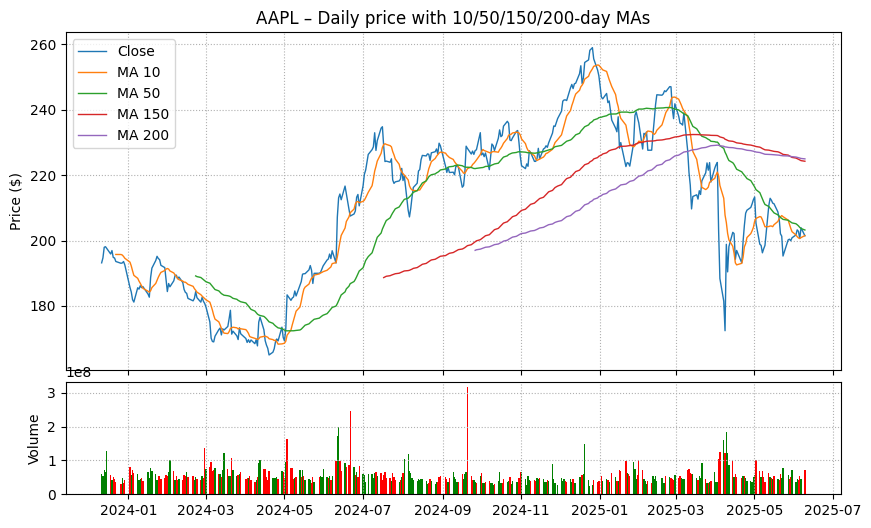

In [36]:
# ── Imports ──────────────────────────────────────────────────────────
import os, requests, time, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import date, timedelta

API_KEY = os.getenv("POLYGON_API_KEY")          # make sure this prints something
assert API_KEY, "POLYGON_API_KEY not found – add it to .env or export in shell"

# ── Helper: download daily bars for the last N months ────────────────
def fetch_daily_bars(ticker: str, months_back: int = 18) -> pd.DataFrame:
    """
    Returns a DataFrame with columns: date, o, h, l, c, v, and unix milliseconds 't'.
    One API call (<=50k rows) – well within the free-tier 5-calls/min limit.
    """
    end   = date.today()
    start = end - timedelta(days = int(months_back * 30.5))
    url = (
        f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/"
        f"{start}/{end}"
        f"?adjusted=true&sort=asc&limit=50000&apiKey={API_KEY}"
    )
    resp = requests.get(url, timeout=30).json()
    if "results" not in resp:
        raise RuntimeError(f"Polygon error: {resp.get('message', resp)}")
    df = (
        pd.DataFrame(resp["results"])
          .assign(date=lambda d: pd.to_datetime(d["t"], unit="ms").dt.tz_localize(None))
          .set_index("date")
          .rename(columns={"o":"open","h":"high","l":"low","c":"close","v":"volume"})
    )
    return df

# ── Helper: plot price, MAs, and coloured volume ─────────────────────
def plot_with_mas(df: pd.DataFrame, ticker: str):
    # Moving averages
    for win in [10, 50, 150, 200]:
        df[f"ma{win}"] = df["close"].rolling(win).mean()

    # Colour map for volume bars
    vol_colors = df.apply(lambda r: "green" if r["close"] >= r["open"] else "red", axis=1)

    # Layout – 3:1 height ratio (price : volume)
    fig = plt.figure(figsize=(10,6))
    gs  = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    ax_price  = fig.add_subplot(gs[0])
    ax_volume = fig.add_subplot(gs[1], sharex=ax_price)

    # Price + MAs
    ax_price.plot(df.index, df["close"], lw=1, label="Close")
    ax_price.plot(df.index, df["ma10"],  lw=1, label="MA 10")
    ax_price.plot(df.index, df["ma50"],  lw=1, label="MA 50")
    ax_price.plot(df.index, df["ma150"], lw=1, label="MA 150")
    ax_price.plot(df.index, df["ma200"], lw=1, label="MA 200")
    ax_price.set_ylabel("Price ($)")
    ax_price.set_title(f"{ticker.upper()} – Daily price with 10/50/150/200-day MAs")
    ax_price.legend(loc="upper left")
    ax_price.grid(True, ls=":")

    # Volume bars
    ax_volume.bar(df.index, df["volume"], color=vol_colors, width=1)
    ax_volume.set_ylabel("Volume")
    ax_volume.grid(True, ls=":")
    plt.setp(ax_price.get_xticklabels(), visible=False)  # hide duplicate labels
    plt.tight_layout()
    plt.show()

# ── One-liner the user can call ──────────────────────────────────────
def plot_stock_with_mas(ticker: str, months_back: int = 18):
    """
    Convenience wrapper: fetch data, compute MAs, chart.
    """
    df = fetch_daily_bars(ticker, months_back=months_back)
    plot_with_mas(df, ticker)

# ── Example call ─────────────────────────────────────────────────────
plot_stock_with_mas("AAPL")   # uncomment to try


/var/folders/cv/nmfv_60118b7v59r0zjz8y_40000gn/T/ipykernel_41085/3383734557.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


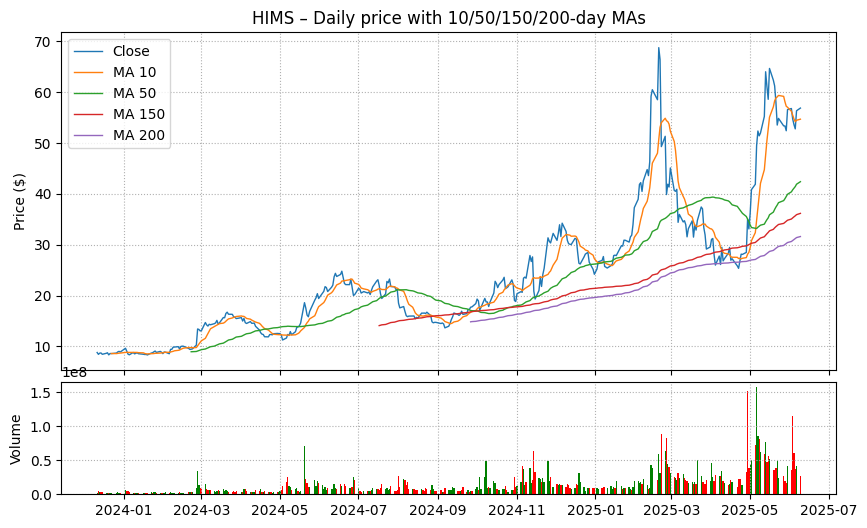

In [57]:
plot_stock_with_mas("HIMS", 18)   # uncomment to try


In [47]:
# --- Imports & settings (keep as-is) ---------------------------------
import os, requests, time, json, textwrap, pandas as pd
API_KEY, RATE_PAUSE = os.getenv("POLYGON_API_KEY"), 13
assert API_KEY, "POLYGON_API_KEY missing"

# --- Grab most-recent report (10-K or 10-Q) --------------------------
def get_latest_report(ticker: str, timeframe: str = "annual") -> dict:
    url = (
        "https://api.polygon.io/vX/reference/financials"
        f"?ticker={ticker}&timeframe={timeframe}&limit=1"
        "&sort=period_of_report_date&order=desc"
        f"&apiKey={API_KEY}"
    )
    r = requests.get(url, timeout=30).json()
    time.sleep(RATE_PAUSE)
    if not r.get("results"):
        raise RuntimeError(f"{ticker}: no {timeframe} financials → {r.get('message', r)}")
    rep = r["results"][0]
    rep["ticker_param"] = ticker       # stash query ticker for later reference
    return rep

# --- Pretty-print all field names in each statement ------------------
def show_field_lists(report: dict):
    fin = report["financials"]

    # Safe header line: fall back to the ticker we sent in the query
    rep_tkr = report.get("ticker", report["ticker_param"])
    end_dt  = report.get("period_of_report_date")
    print(f"Ticker: {rep_tkr} • Period end: {end_dt}\n")

    for stmt in ("income_statement", "cash_flow_statement", "balance_sheet"):
        if stmt not in fin:
            print(f"⚠️  {stmt} not present\n")
            continue
        keys = sorted(fin[stmt].keys())
        wrapped = textwrap.fill(", ".join(keys), width=100, subsequent_indent="    ")
        print(f"🗒  {stmt} keys:\n    {wrapped}\n")

    # Show the first 40 JSON lines so you can inspect raw values
    snippet = "\n".join(json.dumps(fin, indent=2).splitlines()[:40])
    print("🔎  Example JSON snippet (first 40 lines):\n" + snippet)

# --- Choose ticker/timeframe & run -----------------------------------
ticker, timeframe = "AAPL", "annual"        # change ticker or use 'quarterly'
report = get_latest_report(ticker, timeframe)
show_field_lists(report)


Ticker: AAPL • Period end: None

🗒  income_statement keys:
    basic_average_shares, basic_earnings_per_share, benefits_costs_expenses, cost_of_revenue,
    costs_and_expenses, diluted_average_shares, diluted_earnings_per_share, gross_profit,
    income_loss_from_continuing_operations_after_tax,
    income_loss_from_continuing_operations_before_tax, income_tax_expense_benefit, net_income_loss,
    net_income_loss_attributable_to_noncontrolling_interest, net_income_loss_attributable_to_parent,
    net_income_loss_available_to_common_stockholders_basic, nonoperating_income_loss,
    operating_expenses, operating_income_loss,
    participating_securities_distributed_and_undistributed_earnings_loss_basic,
    preferred_stock_dividends_and_other_adjustments, research_and_development, revenues,
    selling_general_and_administrative_expenses

🗒  cash_flow_statement keys:
    net_cash_flow, net_cash_flow_continuing, net_cash_flow_from_financing_activities,
    net_cash_flow_from_financing_act

In [52]:
import os, requests, time, pandas as pd
API_KEY     = os.getenv("POLYGON_API_KEY")
RATE_PAUSE  = 13                       # free-tier → 5 calls/min

if not API_KEY:
    raise EnvironmentError("POLYGON_API_KEY not found. Add it to .env or export in your shell!")

# ── 1. Whole-chain snapshot ─────────────────────────────────────────
def chain_snapshot(underlying: str, limit: int = 1000) -> pd.DataFrame:
    url  = f"https://api.polygon.io/v3/snapshot/options/{underlying}"
    url += f"?limit={limit}&apiKey={API_KEY}"
    rows = []
    while url:
        r = requests.get(url, timeout=30).json()
        if "results" not in r:                    # ← robust check
            raise RuntimeError(f"Snapshot error for {underlying}: {r.get('message', r)}")
        rows.extend(r["results"])
        url = r.get("next_url")
        if url: url += f"&apiKey={API_KEY}"
        time.sleep(RATE_PAUSE)
    return pd.DataFrame(rows)

# ── 2. Contract directory query ─────────────────────────────────────
def list_contracts(underlying, exp=None, ctype=None, strike=None, limit=1000):
    url = ("https://api.polygon.io/v3/reference/options/contracts"
           f"?underlying_ticker={underlying}&limit={limit}&apiKey={API_KEY}")
    if exp:    url += f"&expiration_date={exp}"
    if ctype:  url += f"&contract_type={ctype}"           # 'call' | 'put'
    if strike: url += f"&strike_price={strike}"

    rows, nxt = [], url
    while nxt:
        r = requests.get(nxt, timeout=30).json()
        if "results" not in r:
            raise RuntimeError(f"Contract lookup error: {r.get('message', r)}")
        rows.extend(r["results"])
        nxt = r.get("next_url")
        if nxt: nxt += f"&apiKey={API_KEY}"
        time.sleep(RATE_PAUSE)
    return pd.DataFrame(rows)

# ── 3. Historical OHLCV for ONE option ─────────────────────────────
def contract_history(opt_ticker, start, end, timespan="day"):
    url = (f"https://api.polygon.io/v2/aggs/ticker/O:{opt_ticker}/range/1/{timespan}/"
           f"{start}/{end}?adjusted=true&sort=asc&apiKey={API_KEY}")
    r = requests.get(url, timeout=30).json()
    if "results" not in r:
        raise RuntimeError(f"History error for {opt_ticker}: {r.get('message', r)}")
    df = pd.DataFrame(r["results"])
    df["date"] = pd.to_datetime(df["t"], unit="ms")
    return df.set_index("date")

# ── Quick demos ─────────────────────────────────────────────────────
# A. entire NVDA chain snapshot (today)
nvda_chain = chain_snapshot("NVDA")
print(nvda_chain[["contract_type", "strike_price", "expiration_date",
                  "implied_volatility"]].head())

# B. all AAPL calls expiring 2025-06-27
wk_calls = list_contracts("AAPL", exp="2025-06-27", ctype="call")
print(len(wk_calls), "contracts")

# C. daily history of one contract
hist = contract_history("NVDA250726C00950000", "2025-02-01", "2025-06-10")
print(hist.tail())




RuntimeError: Snapshot error for NVDA: You are not entitled to this data. Please upgrade your plan at https://polygon.io/pricing

TypeError: unsupported operand type(s) for |: 'type' and 'NoneType'

In [59]:
# ── Imports & basic config ───────────────────────────────────────────
import os, requests, time, pandas as pd
from typing import Optional       # ← classic type-hint style

API_KEY     = os.getenv("POLYGON_API_KEY")
RATE_PAUSE  = 13                  # free tier → 5 calls / minute
assert API_KEY, "POLYGON_API_KEY missing – add it to .env or export"

# ── Core helper: contract directory query ────────────────────────────
def list_contracts(
    underlying: str,
    expiration: Optional[str]  = None,   # 'YYYY-MM-DD'
    ctype:      Optional[str]  = None,   # 'call' or 'put'
    strike_min: Optional[float] = None,
    strike_max: Optional[float] = None,
    limit: int = 1000
) -> pd.DataFrame:
    """
    Return a DataFrame of option contracts that match the filters.
    Uses only /v3/reference/options/contracts (free tier).
    """
    url  = ("https://api.polygon.io/v3/reference/options/contracts"
            f"?underlying_ticker={underlying}&limit={limit}&apiKey={API_KEY}")
    if expiration: url += f"&expiration_date={expiration}"
    if ctype:      url += f"&contract_type={ctype}"
    if strike_min: url += f"&strike_price.gte={strike_min}"
    if strike_max: url += f"&strike_price.lte={strike_max}"

    rows, nxt = [], url
    while nxt:
        resp = requests.get(nxt, timeout=30).json()
        if "results" not in resp:
            raise RuntimeError(f"Polygon error: {resp.get('message', resp)}")
        rows.extend(resp["results"])
        nxt = resp.get("next_url")
        if nxt: nxt += f"&apiKey={API_KEY}"
        time.sleep(RATE_PAUSE)          # throttle
    return pd.DataFrame(rows)

# ── Demo: whole NVDA directory, then filter AAPL calls ---------------
nvda_dir = list_contracts("NVDA")
print("Total NVDA contracts:", len(nvda_dir))
print(nvda_dir[["ticker","contract_type","expiration_date","strike_price"]].head())

calls = list_contracts("AAPL", expiration="2025-06-27", ctype="call")
print(len(calls), "AAPL calls expiring 2025-06-27")


Total NVDA contracts: 4492
                  ticker contract_type expiration_date  strike_price
0  O:NVDA250613C00010000          call      2025-06-13          10.0
1  O:NVDA250613C00015000          call      2025-06-13          15.0
2  O:NVDA250613C00020000          call      2025-06-13          20.0
3  O:NVDA250613C00025000          call      2025-06-13          25.0
4  O:NVDA250613C00030000          call      2025-06-13          30.0
43 AAPL calls expiring 2025-06-27


TypeError: 'NoneType' object is not subscriptable

In [62]:
import requests, pandas as pd, io, zipfile, textwrap

SERIES_URL = "https://marketdata.theocc.com/series-download?output=txt"   # txt or zip
resp = requests.get(SERIES_URL, timeout=60)
resp.raise_for_status()

# If the server sent a zip (check header), unzip in-memory
content = resp.content
if resp.headers.get("Content-Type","").startswith("application/zip"):
    z = zipfile.ZipFile(io.BytesIO(content))
    content = z.read(z.namelist()[0])

# OCC Series file is **fixed-width**: use layout in the PDF
colspecs = [(0,4),(4,5),(5,13),(13,43),(43,49),(49,51),(51,53),(53,57),
            (57,62),(62,65),(65,67),(67,70),(70,74)]   # byte offsets 1-based→0-based
names    = ["exchange","add_del","activity_date","symbol_name","option_symbol",
            "month","day","year","strike_int","strike_dec",
            "call_ind","put_ind","list_or_delist"]

df = pd.read_fwf(io.BytesIO(content), colspecs=colspecs, names=names)
print(df.head())


Empty DataFrame
Columns: [exchange, add_del, activity_date, symbol_name, option_symbol, month, day, year, strike_int, strike_dec, call_ind, put_ind, list_or_delist]
Index: []


In [66]:
import io, zipfile, requests, pandas as pd

def fetch_occ_series(output="zip"):
    """
    Downloads OCC Series Download as 'zip' or 'txt' and returns raw bytes.
    Falls back to text if the file isn't zipped even when output='zip'.
    """
    url = f"https://marketdata.theocc.com/series-download?output={output}"
    resp = requests.get(url, timeout=120)
    resp.raise_for_status()
    content = resp.content
    ctype   = resp.headers.get("Content-Type", "")

    # Try zip first if caller asked for it
    if output == "zip" or ctype.startswith("application/zip"):
        try:
            zf   = zipfile.ZipFile(io.BytesIO(content))
            name = zf.namelist()[0]            # there is always exactly one file
            content = zf.read(name)
            print(f"✅ extracted {name} from zip ({len(content)/1e6:.1f} MB)")
        except zipfile.BadZipFile:
            print("⚠️  Server responded with plain text despite 'zip' – falling back")
            # keep `content` as-is (raw text)

    return content  # bytes

# --- get tonight's file (about 30–100 MB) ----------------------------
raw_bytes = fetch_occ_series(output="zip")      # or 'txt'

# --- parse fixed-width into DataFrame --------------------------------
colspecs = [
    (0, 4),(4, 5),(5, 13),(13, 43),(43, 49),
    (49, 51),(51, 53),(53, 57),(57, 62),(62, 65),(65, 67),(67, 70)
]
names = [
    "exchange","add_del","activity_date","symbol_name","option_root",
    "month","day","year","strike_int","strike_dec","call_put","status"
]

df = pd.read_fwf(io.BytesIO(raw_bytes), colspecs=colspecs, names=names, dtype=str)

# --- tidy & filter for NVDA ------------------------------------------
# ---- tidy & filter for NVDA ----------------------------------------
df["root"]         = df["option_root"].str.strip()
df["strike_price"] = df["strike_int"].astype(int) + df["strike_dec"].astype(int)/1000
df["expiration"]   = (
    "20" + df["year"].str.zfill(2) + "-" +
    df["month"].str.zfill(2) + "-" +
    df["day"].str.zfill(2)
)

nvda_df = df[df["root"] == "NVDA"].copy()
print(f"Found {len(nvda_df):,} NVDA option lines")
display(nvda_df.head())


nvda_df = df[df["underlying"] == "NVDA"].copy()



⚠️  Server responded with plain text despite 'zip' – falling back
Found 0 NVDA option lines


,exchange,add_del,activity_date,symbol_name,option_root,month,day,year,strike_int,strike_dec,call_put,status,root,strike_price,expiration


KeyError: 'underlying'

In [69]:
import requests, itertools, collections, textwrap

# 1️⃣  grab tonight’s file as raw text (≈100 MB)
URL  = "https://marketdata.theocc.com/series-download?output=txt"
raw  = requests.get(URL, timeout=120).text        # decode ASCII

lines = raw.splitlines()
print("Total records:", len(lines))

# 2️⃣  show the first 10 records with a ruler
print("\n── first ten raw records ──")
for ln in lines[:10]:
    print(ln)
    print("".join(str((i//10)%10) if i % 10 == 0 else "-" for i in range(len(ln))))
    print()

# 3️⃣  grab the root-symbol slice the PDF claims (columns 43-48),
#     trim spaces, then tally the 10 most-frequent roots
roots = (ln[43:49].strip() for ln in lines)   # adjust 43 / 49 after eyeballing
counter = collections.Counter(roots)
print("── ten most common root symbols ──")
for root, cnt in counter.most_common(10):
    print(f"{root:6} {cnt:,}")


Total records: 0

── first ten raw records ──
── ten most common root symbols ──
